# Data load

In [2]:
# import relevant packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
import rdkit.Chem.Descriptors

In [3]:
# read in dataframe with all sulfonyl fluorides and descriptors, indexed by ID columns

dft = pd.read_csv('DFT-qikprop_SFs.csv', index_col='ID')

# Functional group and MW filtering

In [4]:
# remove any thiolates or salts that may remain in dataset

to_drop = []
for s in dft['SMILES']:
    if len(s.split('.')) > 1:
        to_drop.append(s)
    if len(s.split('S-')) > 1:
        to_drop.append(s)
        
to_drop = pd.DataFrame(to_drop).rename(columns={0:'SMILES'})

dft = dft[~dft['SMILES'].isin(to_drop['SMILES'])]

In [5]:
# remove undesired functionality, large MW compounds

# removes aryl & alkyl iodides, nitro groups, compounds with 3 or more aryl thiols, and alkyl thiols
iodides = ['cI', 'C-I']
nitro = ['[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]']
multiple_aryl_thiols = ['cS.cS.cS.cS.cS.cS', 'cS.cS.cS.cS.cS', 'cS.cS.cS.cS', 'cS.cS.cS']
alkyl_thiols = ['[CX4]-[#16H]']

patterns_to_remove = iodides + nitro + alkyl_thiols + multiple_aryl_thiols
smiles_to_remove = []

my_smiles = dft['SMILES']

#removes any compounds that match functional groups listed above, and then goes through dataset again and removes anything with a MW > 600
for pattern in patterns_to_remove:
    pat = Chem.MolFromSmarts(pattern)
    for smile in my_smiles:
        mol = Chem.MolFromSmiles(smile)
        has_substructure = mol.HasSubstructMatch(pat)
        if has_substructure == True:
            smiles_to_remove.append(smile)
        else:
            mw = Chem.Descriptors.ExactMolWt(mol)
            if mw > 600:
                smiles_to_remove.append(smile)

smiles_to_remove = set(smiles_to_remove)

In [6]:
dft = dft[~dft['SMILES'].isin(smiles_to_remove)]

# Standardization of descriptor dataset

In [7]:
# The following 3 lines are to supress all the rdkit warnings. Remove them to show the warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# remove any duplicate sulfonyl fluorides based on InChIKey
dft = dft.drop_duplicates('InChIKey')

In [9]:
# drop SMILES and InChIKey entries from descriptor set so that they don't get included in dimensionality reduction

from sklearn.preprocessing import scale
df = dft.drop(['SMILES', 'InChIKey'], axis=1)
info = dft[['SMILES', 'InChIKey']]

In [10]:
# view df to confirm relevant changes have been made
df

,#acid,#amide,#amidine,#amine,#in34,#in56,#metab,#NandO,#noncon,#nonHatm,...,Sterimol_B5_S_C_SF(Å)_morfeus_Boltz,Sterimol_B5_S_F(Å)_morfeus_Boltz,Sterimol_L_S_C_SF(Å)_morfeus_Boltz,Sterimol_L_S_F(Å)_morfeus_Boltz,volume,volume(Bohr_radius³/mol)_Boltz,WPSA,η_Boltz,μ_Boltz,ω_Boltz
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,6,1,2,0,11,...,3.257363,7.695641,8.164335,3.500092,567.642,1283.913000,50.441,0.300910,-0.186925,0.058060
1,0,0,0,0,0,6,1,3,0,11,...,3.264815,7.502653,7.924592,3.504128,537.024,1212.748460,44.453,0.273455,-0.156437,0.044750
2,0,0,0,0,0,6,0,3,0,13,...,3.260160,8.746259,9.047582,3.495756,614.815,1336.171000,116.569,0.275750,-0.228265,0.094480
3,1,0,0,0,0,6,0,4,0,13,...,3.258301,8.661083,9.061441,3.497248,590.831,1333.043045,50.127,0.284350,-0.214175,0.080660
4,0,0,0,0,0,6,0,2,0,11,...,3.260375,8.209172,8.674962,3.497924,559.713,1386.985000,127.620,0.283530,-0.193505,0.066030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3959,0,0,0,0,0,6,1,3,0,12,...,4.777579,6.621097,7.122608,3.499518,573.969,1482.025836,43.586,0.295542,-0.194156,0.063779
3960,0,0,0,0,0,6,1,3,0,12,...,4.685789,7.728084,7.642112,3.499672,589.875,1296.450846,50.417,0.294847,-0.187783,0.059812
3961,0,0,0,0,0,12,2,5,0,21,...,7.513162,8.662433,8.706110,4.001340,935.090,2277.938482,50.444,0.238519,-0.177985,0.066411


In [11]:
# standardize the descriptor set and index by ID values

df = pd.DataFrame(scale(df),index=df.index, columns=df.columns)

In [12]:
total_dim = len(list(df.columns))
print(f"Current dimensions: {total_dim}")

Current dimensions: 102


In [13]:
# drop any zero-variance features
zero_std_cols = df.columns[df.std() == 0] 
df = df[df.columns.difference(zero_std_cols)]
print (f"Dropping {len(zero_std_cols)} features {zero_std_cols}")

Dropping 0 features Index([], dtype='object')


In [14]:
total_dim = len(list(df.columns))
print(f"Current dimensions: {total_dim}")

Current dimensions: 102


In [15]:
# drop any highly correlated features currently collinearity is set to cutoff at 80%. 
# Change this value if you want to implement a higher or lower collinearity cutoff

df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)] 
df = df.drop(to_drop, axis=1)

In [16]:
# view features that have been dropped as a result
print (f"Dropping {len(to_drop)} features {to_drop}")

Dropping 53 features ['#nonHatm', '#ringatoms', '%Vbur_C_SF_2.5Å_Boltz', '%Vbur_C_SF_3.0Å_Boltz', '%Vbur_C_SF_3.5Å_Boltz', '%Vbur_C_SF_4.0Å_Boltz', '%Vbur_S_2.5Å_Boltz', '%Vbur_S_3.0Å_Boltz', '%Vbur_S_3.5Å_Boltz', '%Vbur_S_4.0Å_Boltz', 'accptHB', 'dipole', 'FISA', 'glob', 'Hirsh_atom_dipole_C_SF_Boltz', 'Hirsh_atom_dipole_F_Boltz', 'Hirsh_atom_dipole_S_Boltz', 'Hirsh_charge_C_SF_Boltz', 'Hirsh_charge_F_Boltz', 'Hirsh_charge_S_Boltz', 'Hirsh_CM5_charge_C_SF_Boltz', 'Hirsh_CM5_charge_F_Boltz', 'Hirsh_CM5_charge_S_Boltz', 'IP(eV)', 'mol MW', 'NBO_charge_C_SF_Boltz', 'NBO_charge_F_Boltz', 'NBO_O_avg_Boltz', 'PercentHumanOralAbsorption', 'polar_iso(Debye)_Boltz', 'PSA', 'pyramidalization_Agranat-Radhakrishnan_S_Boltz', 'pyramidalization_Gavrish_S(°)_Boltz', 'QPlogBB', 'QPlogKp', 'QPlogPC16', 'QPlogPo/w', 'QPlogPoct', 'QPlogPw', 'QPlogS', 'QPPCaco', 'QPpolrz', 'SAamideO', 'SASA', 'SASA_surface_area(Å²)_Boltz', 'SASA_volume(Å³)_Boltz', 'Sterimol_B5_S_F(Å)_morfeus_Boltz', 'Sterimol_L_S_C_SF(Å)

In [17]:
# print list of remaining features
print (list(df.columns))

['#acid', '#amide', '#amidine', '#amine', '#in34', '#in56', '#metab', '#NandO', '#noncon', '#rotor', '#rtvFG', '#stars', '%Vbur_C_SF_2.0Å_Boltz', '%Vbur_S_2.0Å_Boltz', 'angle_C_SF_S_F(°)_Boltz', 'ChelpG_charge_C_SF_Boltz', 'ChelpG_charge_F_Boltz', 'ChelpG_charge_S_Boltz', 'CIQPlogS', 'CNS', 'dip^2/V', 'dipole(Debye)_Boltz', 'distance_C_SF_F(Å)_Boltz', 'distance_C_SF_S(Å)_Boltz', 'distance_S_F(Å)_Boltz', 'donorHB', 'EA(eV)', 'FOSA', 'HOMO_Boltz', 'HumanOralAbsorption', 'Jm', 'LUMO_Boltz', 'NBO_charge_S_Boltz', 'NMR_shift_C_SF_Boltz', 'NMR_shift_F_Boltz', 'PISA', 'polar_aniso(Debye)_Boltz', 'QPlogHERG', 'QPlogKhsa', 'QPPMDCK', 'RuleOfFive', 'RuleOfThree', 'SAfluorine', 'SASA_sphericity_Boltz', 'Sterimol_B1_S_C_SF(Å)_morfeus_Boltz', 'Sterimol_B1_S_F(Å)_morfeus_Boltz', 'Sterimol_B5_S_C_SF(Å)_morfeus_Boltz', 'Sterimol_L_S_F(Å)_morfeus_Boltz', 'WPSA']


In [18]:
print(len(list(df.columns)))

49


# Dimensionality reduction

In [24]:
# import relevant packages
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
from umap import UMAP

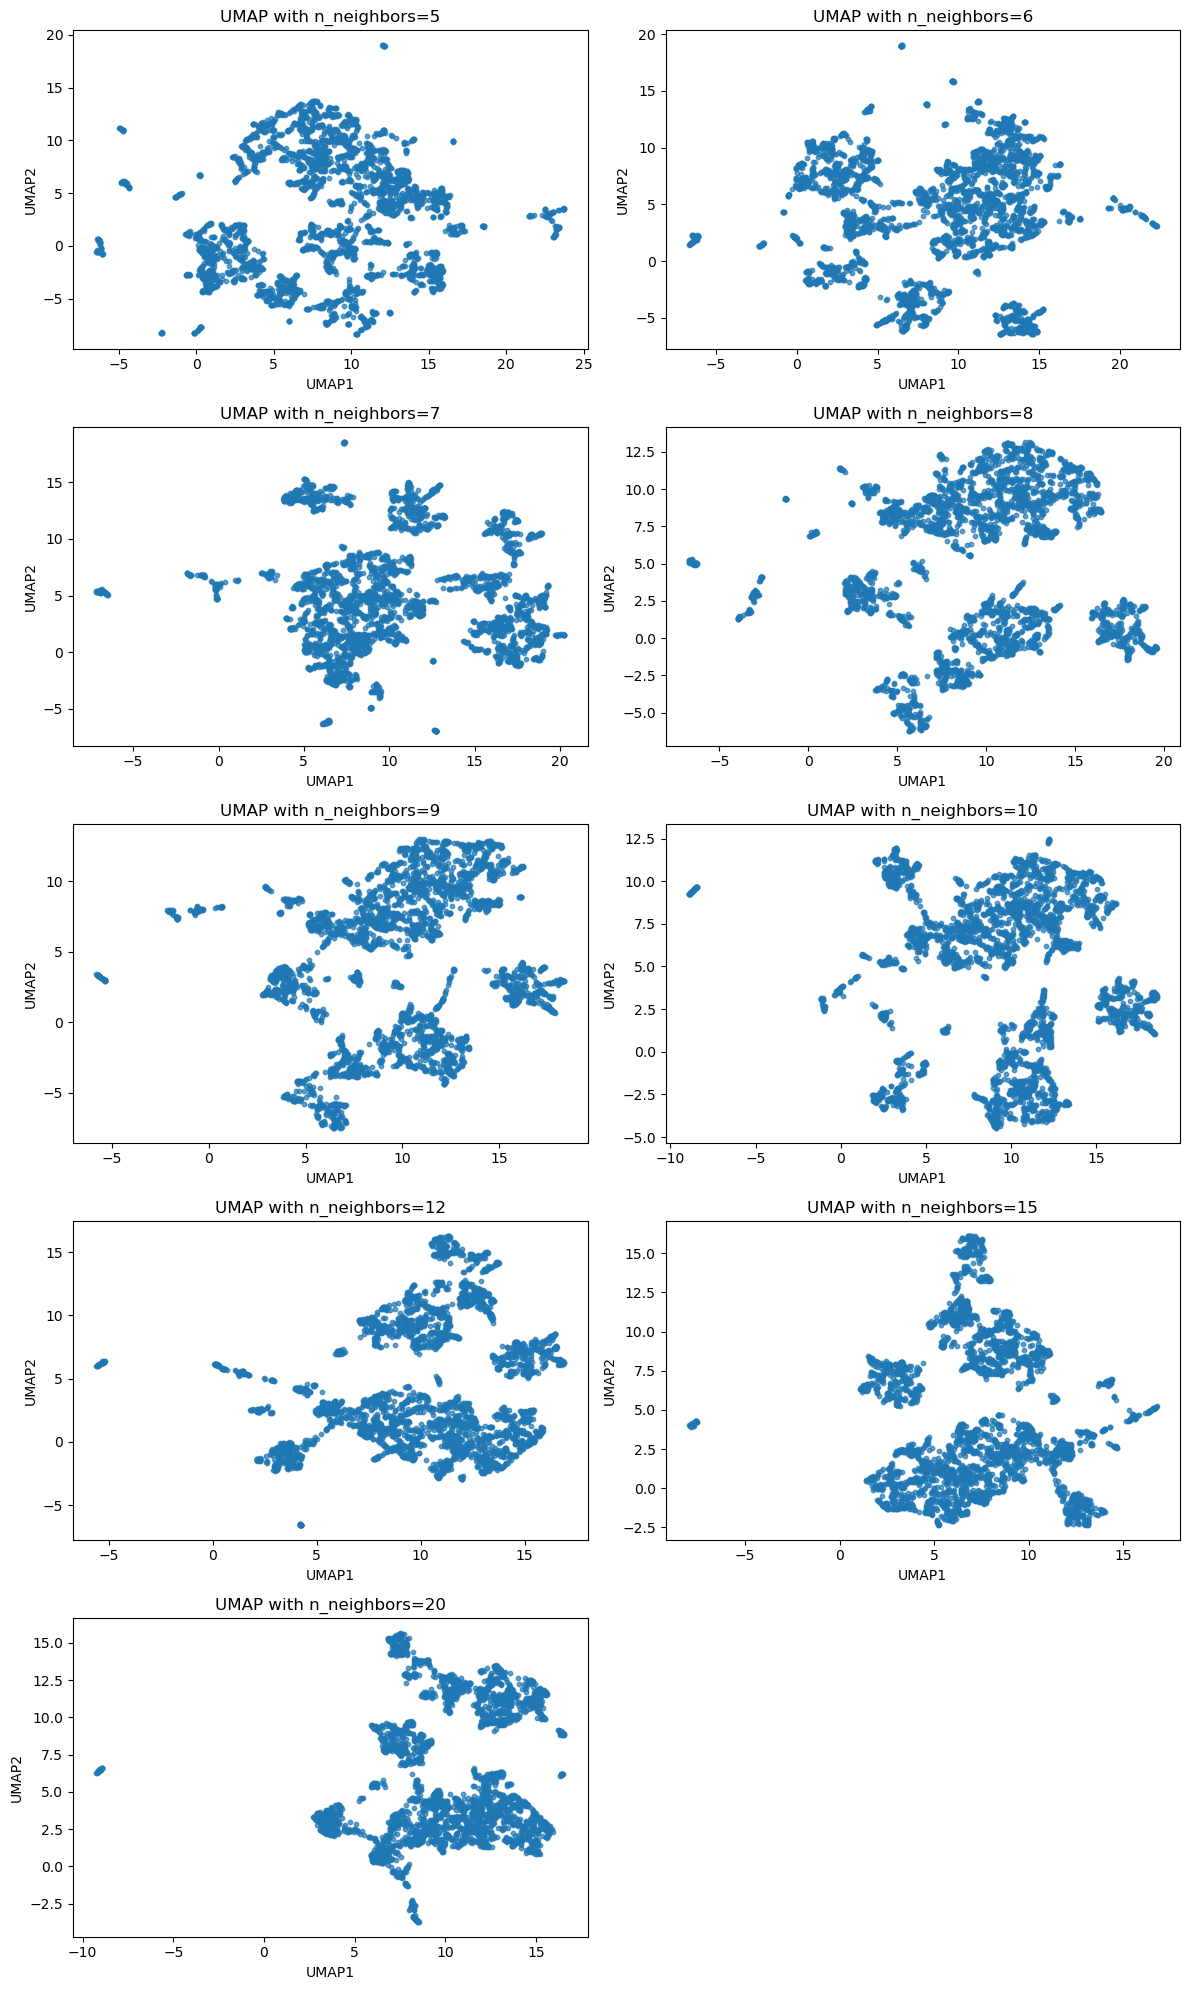

In [25]:
# UMAP section to explore different n_neighbors and view all plots 
#(comment out this block of code once you are decided on hyperparameters and use the cell blocks below)

# List of n_neighbors values to explore
n_neighbors_list = [5, 6, 7, 8, 9, 10, 12, 15, 20]  # Change this to n_neighbors you would like to view 

# Determine grid size dynamically
num_plots = len(n_neighbors_list)
rows = int(np.ceil(num_plots / 2))  # Adjust row count dynamically

fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))  # Flexible grid
axes = axes.flatten()  # Make it easier to index

# UMAP exploration with n_neighbors_list as determined above
for i, n_neighbors in enumerate(n_neighbors_list):
    umap_2d = UMAP(n_components=2, n_neighbors=n_neighbors, random_state=0, min_dist=0.25, n_jobs=1) #adjust min_dist, n_components as desired 
    embedding = umap_2d.fit_transform(df)

    ax = axes[i]  # Select subplot dynamically
    ax.scatter(embedding[:, 0], embedding[:, 1], s=10, alpha=0.7)
    ax.set_title(f"UMAP with n_neighbors={n_neighbors}")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

# Hide any unused subplots (if num_plots is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# view plots below - note this takes a while to generate all the plots - be patient :) 
plt.tight_layout()
plt.show()

In [26]:
# define the dimensionalities of the reduced representation to study

largest_dim = len(list(df.columns)) -1 # subtract 1 b/c don't include the index
print(f"Largest dimension is: {largest_dim}")

# if you want to study a smaller number of reduced representations, change this list
dims = [largest_dim, 30, 25, 20, 10, 5, 2]
print(dims)

Largest dimension is: 48
[48, 30, 25, 20, 10, 5, 2]


In [27]:
# dictionary to store data at different levels of dimensionality reduction
dfs={}

In [28]:
# UMAP section
# adjust hyperparameters (n_neighbors, min_dist) as determined by plots above

for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=8, random_state=0, min_dist=0.25, n_jobs=1).fit_transform(df), index=df.index)

In [29]:
# PCA section

pc = pd.DataFrame(PCA(n_components=None).fit_transform(df), index=df.index)
for dim in dims:
    key = f"pc{dim}"
    dfs[key] = pc.iloc[:, :dim]

In [30]:
dimensionsionality_reduction_dfs_saved = dfs # save these in case you want to go back to this point

# Visualization

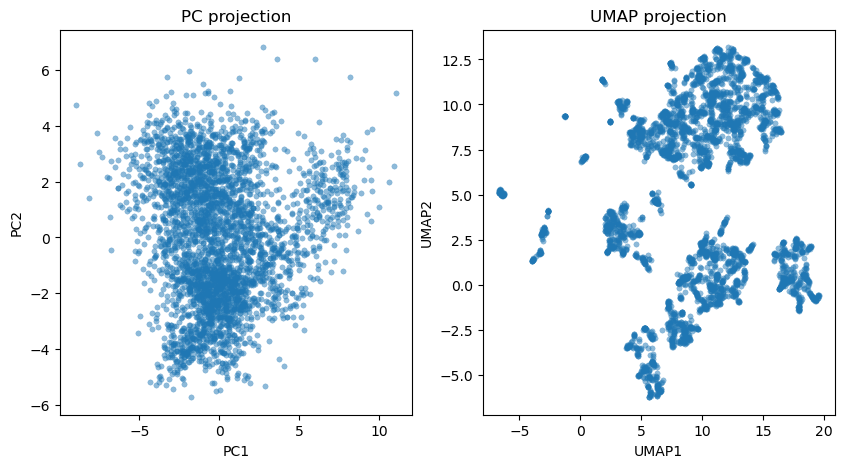

In [31]:
# Visualize the UMAP and PCA embeddings
f, ax = plt.subplots(1, 2, figsize=(10, 5)) #, dpi=200)

dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']


_=sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=15, alpha=0.5, linewidth=0.25, edgecolor='face', ax=ax[0]).set_title("PC projection") 
_=sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=15, alpha=0.5, linewidth=0.25, edgecolor='face', ax=ax[1]).set_title("UMAP projection")

# Silhouette score optimization

In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from sklearn.metrics import silhouette_score

In [33]:
# Define the number of clusters to study
N_CLS_list = list(range(5, 20))

In [34]:
def silhouette_scores_hierarchical(data, n_cls_list):
    """helper function to compute a silhouette score for hierarchical cluster
    ing using Ward linkage"""

    z = linkage(data, method='ward')
    
    result = pd.Series(index=n_cls_list, dtype=float) 
    for n_cls in n_cls_list:
        cls = fcluster(z, n_cls, criterion='maxclust')
        result.loc[n_cls] = silhouette_score(data, cls) 
    return result

In [35]:
# populate silhouette scores for all number of clusters and all dimensionality reductions that are pre-calculated
silh_scores = pd.DataFrame(index=N_CLS_list)


for key, value in dfs.items():
    silh_scores[key] = silhouette_scores_hierarchical(value, N_CLS_list)

/var/folders/pv/z49yf__x30zbm7v4yl9t7gxw0000gn/T/ipykernel_95325/857172556.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  silh_scores.groupby(silh_scores.columns.str.startswith('pc'), axis=1).plot(xlabel='number of clusters',


False    Axes(0.125,0.11;0.775x0.77)
True     Axes(0.125,0.11;0.775x0.77)
dtype: object

<Figure size 800x800 with 0 Axes>

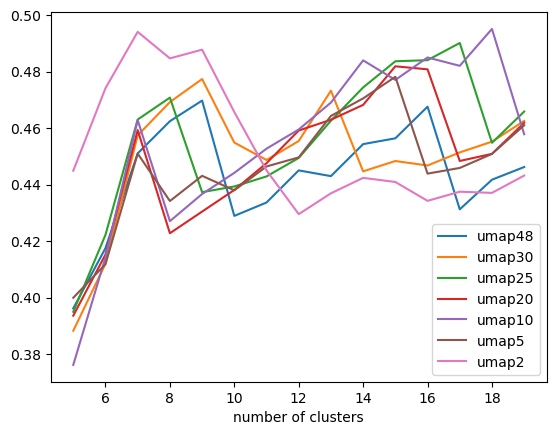

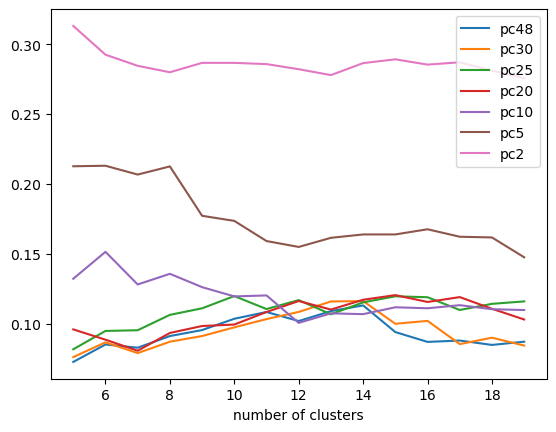

In [36]:
# plot the silhouette scores

plt.figure(figsize=(4,4), dpi=200)

silh_scores.groupby(silh_scores.columns.str.startswith('pc'), axis=1).plot(xlabel='number of clusters',
label='silhouette score')

In [37]:
# Decide how many clusters to use
clustering = "umap10"
min_clusters = 5
max_clusters = 20
score_subset = silh_scores[silh_scores.index <= max_clusters][clustering]
score_subset = score_subset[score_subset.index >= min_clusters]
score_subset.idxmax()

18

# Final clustering

In [41]:
# final number of clusters to produce for UMAP
NCLS = 7

In [42]:
# linkage and clustering for selected featurization
z = linkage(dfs['umap10'], method="ward") 
cls = fcluster(z, NCLS, criterion='maxclust')

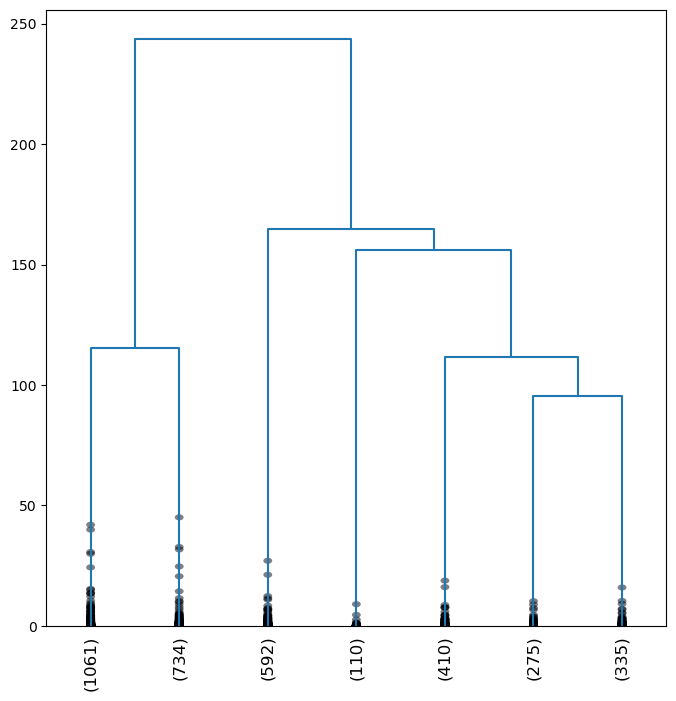

In [43]:
# plot the dendrogram
plt.figure(figsize=(8, 8))
_=dendrogram(z, truncate_mode='lastp', p=NCLS, show_contracted=True, leaf_rotation=90, color_threshold=0)

In [44]:
umap2 = pd.merge(left=info, right=dfs['umap2'], left_index=True, right_index=True).reset_index()
umap2['cluster'] = cls

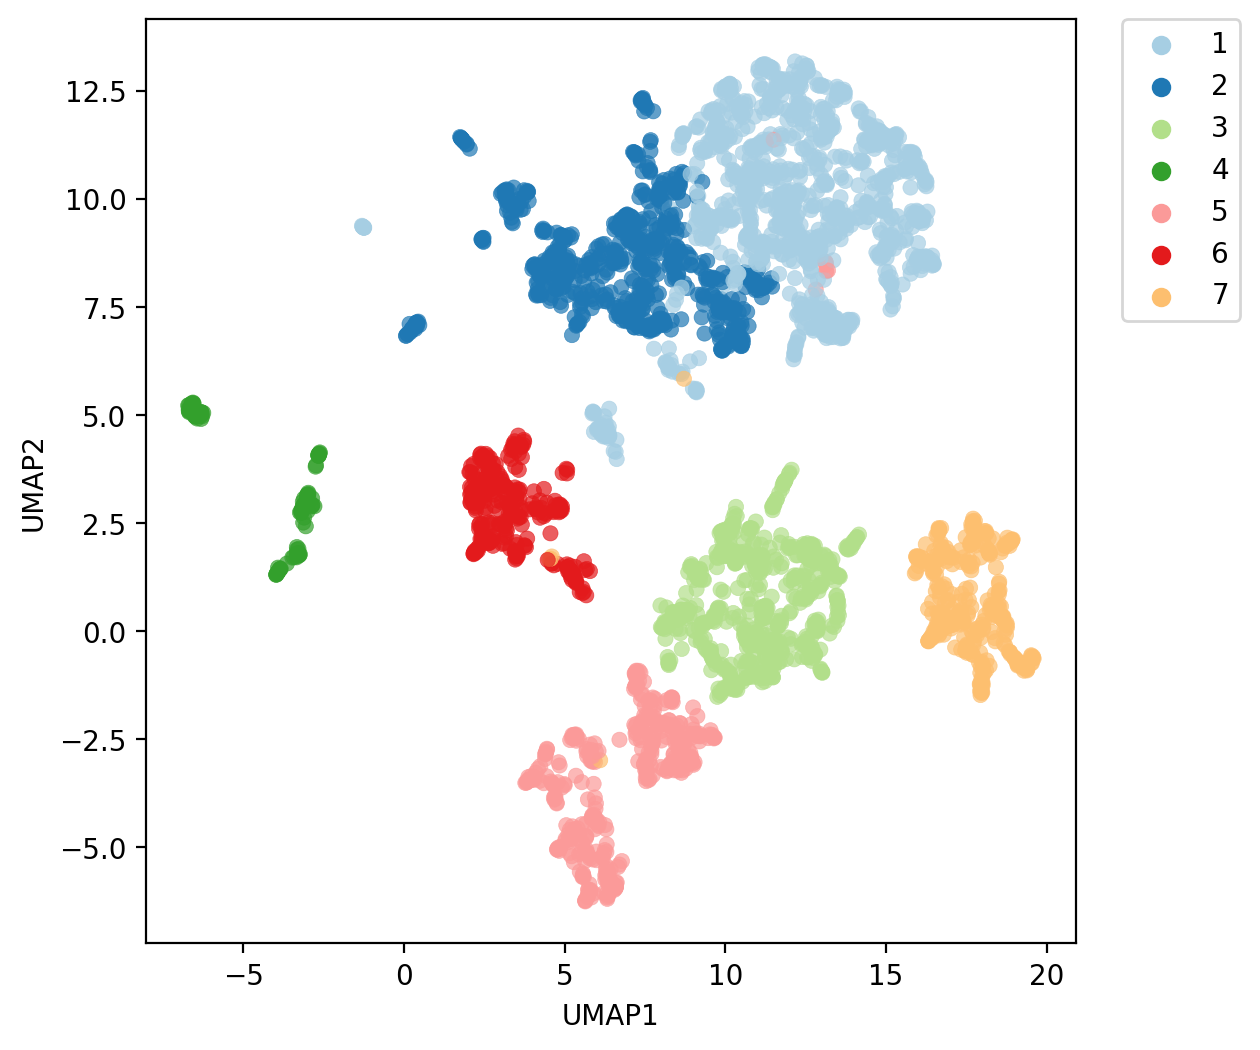

In [45]:
# plot clustering

fig = plt.figure(figsize=(6, 6), dpi=200)

sns.scatterplot(x="UMAP1", y="UMAP2", data=umap2, s=30, alpha=0.7, linewidth=0.25, edgecolor='face', palette='Paired', legend='full', hue='cluster')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [47]:
# save post-clustering dataframe 
dfs["umap2"].to_csv('boltz_DFT_qikprop_df.csv') 
np.savetxt('boltz_DFT_qikprop_df_cls.csv', cls, delimiter=",")

# save final df and list of smiles in each cluster
final_df = dfs["umap2"].copy(deep=True)
final_df["cluster"] = cls
#final_df.to_csv('boltz_only_DFT_only.csv') 

In [48]:
# concatenate final df with SMILES and InChIKey values

# Load the new dataset containing SMILES and InChIKey
new_file_path = "SF_updatedDFT_index_only.csv"  # Update with the actual path if needed
df_new = pd.read_csv(new_file_path)

# Merge the datasets based on the "ID" column
df_merged = final_df.merge(df_new, on="ID", how="left")

# Rename columns for clarity
df_merged.rename(columns={"SMILES": "smiles", "InChIKey": "InChIKey"}, inplace=True)

# Save the merged dataset to a new CSV file
output_file = "boltz_DFT_qikprop_df.csv"
df_merged.to_csv(output_file, index=False)
print(f"Merged dataset saved as {output_file}")

Merged dataset saved as boltz_DFT_qikprop_df.csv


# Plot PyFluor and hand-selected reagents on top of chemical space to see coverage

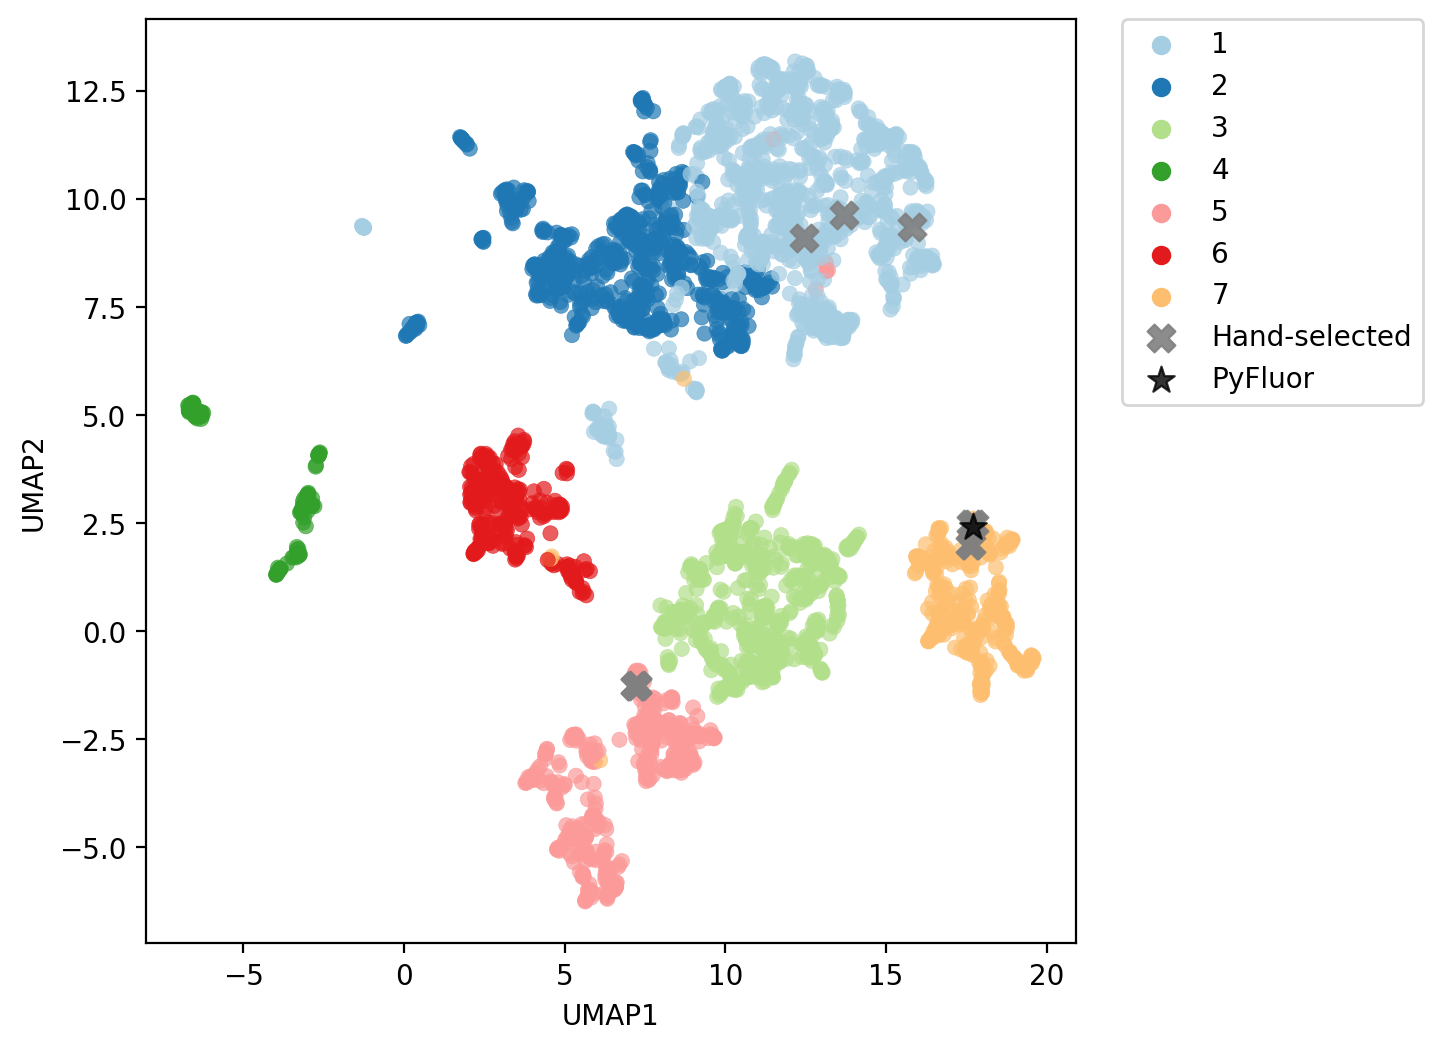

In [49]:
# scatter plot of UMAP1 vs. UMAP2 color-coded by cluster with certain SMILES marked as gray star

# Convert SMILES to InChIKeys for PyFluor
PyFluor_smiles = ['O=S(C1=NC=CC=C1)(F)=O']

PyFluor_inchikeys = [Chem.MolToInchiKey(Chem.MolFromSmiles(smiles)) for smiles in PyFluor_smiles]

# Convert SMILES to InChIKeys for **new hand-selected reagents**
hand_selected_smiles = [
    'O=S(C1=NN=CC=C1)(F)=O',  
    'O=S(C1=NC=NC=C1)(F)=O',  
    'O=S(C1=NC=CN=C1)(F)=O',
    'O=S(C1=NC=CC=N1)(F)=O',
    'ClC1=CC(S(=O)(F)=O)=NC=C1',
    'ClC(C=C1)=CN=C1S(=O)(F)=O',
    'CC1=CC(S(=O)(F)=O)=NC=C1',
    'CC(C=C1)=CN=C1S(=O)(F)=O',
    'ClC(C=C1)=CC=C1S(=O)(F)=O',
    'FC(F)(F)C(C=C1)=CC=C1S(=O)(F)=O',
    '[O-][N+](C(C=C1)=CC=C1S(=O)(F)=O)=O',
    'CC(C=C1)=CC=C1S(=O)(F)=O',
    '[O-][N+](C1=CC=CC=C1S(=O)(F)=O)=O',
]

hand_selected_inchikeys = [Chem.MolToInchiKey(Chem.MolFromSmiles(smiles)) for smiles in hand_selected_smiles]


# Create new columns to identify both sets of hand-selected entries
df_merged["PyFluor"] = df_merged["InChIKey"].isin(PyFluor_inchikeys)
df_merged["hand-selected"] = df_merged["InChIKey"].isin(hand_selected_inchikeys)

# Create the scatter plot
fig = plt.figure(figsize=(6, 6), dpi=200)


# main scatter plot
sns.scatterplot(
    x="UMAP1", y="UMAP2",
    data=df_merged[(df_merged["PyFluor"] == False) & (df_merged["hand-selected"] == False)],
    s=30, alpha=0.7, linewidth=0.25, edgecolor='face',
    palette='Paired', legend='full', hue='cluster', marker="o"
)

# Overlay the **new hand-selected reagents** as red triangles
sns.scatterplot(
    x="UMAP1", y="UMAP2", data=df_merged[df_merged["hand-selected"] == True],
    s=100, color='gray', alpha=0.9, marker='X', edgecolor='face', label="Hand-selected")

# Overlay the **original** hand-selected points as gray stars
sns.scatterplot(
    x="UMAP1", y="UMAP2", data=df_merged[df_merged["PyFluor"] == True],
    s=100, color='black', alpha=0.8, marker='*', edgecolor='face', label="PyFluor"
)

# Adjust the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
#plt.title("UMAP Clustering Scatter Plot with Hand-Selected Entries & New Reagents")

# Show the plot
plt.show()


# Plot training & validation set on top

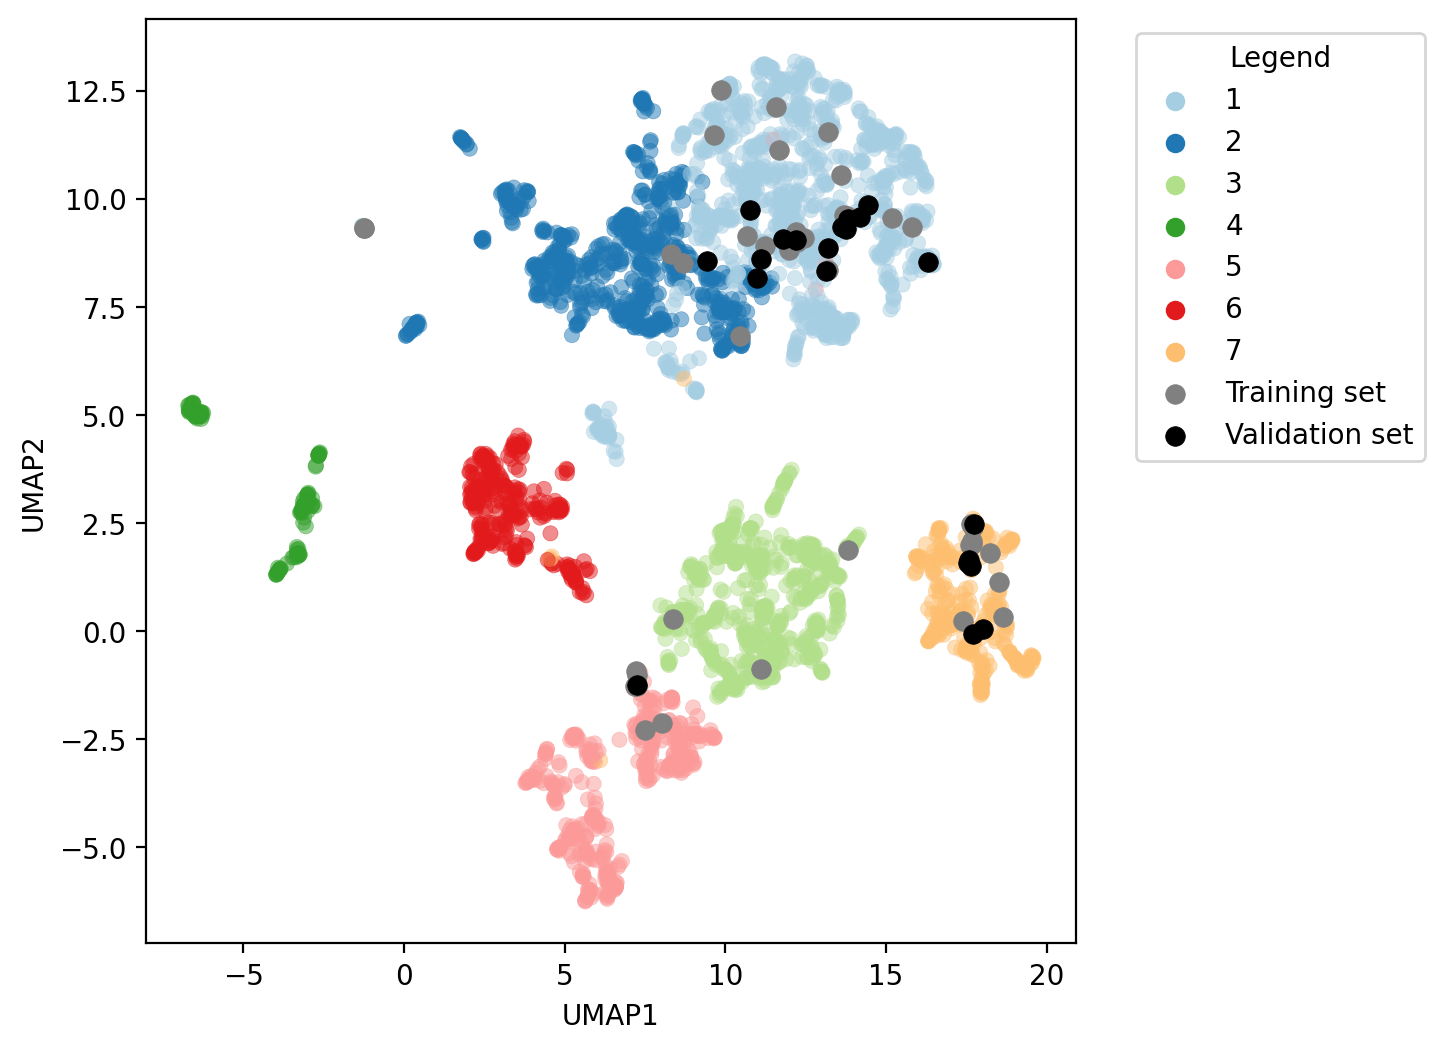

In [50]:
# Load the experimental data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
df_dft = pd.read_csv("boltz_DFT_qikprop_df.csv") # dataframe with UMAP1 and UMAP2 coordinates that was exported above
df_exp = pd.read_csv("experimental_data_SFs.csv") # list of sulfonyl fluorides tested in model reaction indexed by ID values only

# Merge datasets on ID to get test_set values
df_merged = df_dft.merge(df_exp[['ID', 'test_set']], on='ID', how='inner')

# Create the plot
plt.figure(figsize=(6, 6), dpi=200)

# Plot the original UMAP projection with clusters
sns.scatterplot(
    data=df_dft, x='UMAP1', y='UMAP2', hue='cluster', palette='Paired',
    s=30, alpha=0.5, linewidth=0.25, edgecolor='face', marker="o", legend='full'
)

# Overlay experimental data points with specific test_set values
sns.scatterplot(
    data=df_merged[df_merged['test_set'].isin([0, 1])], x='UMAP1', y='UMAP2',
    color='gray', s=50, alpha=1.0, linewidth=0.25, edgecolor='face', marker="o", label='Training set'
)

sns.scatterplot(
    data=df_merged[df_merged['test_set'] == 2], x='UMAP1', y='UMAP2',
    color='black', s=50, alpha=1.0, linewidth=0.25, edgecolor='face', marker="o", label='Validation set'
)

# Final plot adjustments
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
#plt.title('UMAP Projection with Experimental Data Overlay')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)

# Show the plot
plt.show()